In [1]:
import pandas as pd
import numpy as np
import lightgbm
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap

In [2]:
warnings.filterwarnings('ignore')

In [3]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [4]:
train_df_final.head()

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,dew_point_avg,humidity_avg,dew_humidity_interaction,...,pressure_tendency_sq_X_clim_doy_cos,dew_change_day_X_humidity_avg,clim_doy_cos_X_slp_avg_base,clim_doy_cos_slp_X_doy_sin_sq,dp_evening_avg_X_pressure_tendency,DCD_Hum_X_log_elev,LMC_X_ratio_STA_elev_div_hum,ratio_TEMNA_div_wind,R_LMC_STA_WIND_X_elev_sq,precip_contrib_max_hr_X_elev_sq
0,0,-2.707143,-3.992857,115.62,0.017213,0.999852,9.426812,-16.808333,46.875000,-787.890625,...,-9.771338,268.750000,-2799.887516,-0.829606,32.648333,1276.645533,-31.003020,1.760390,-98597.507314,1548.416765
1,1,-3.646429,-1.653571,115.62,0.034422,0.999407,9.437325,-17.466667,45.500000,-794.733333,...,-4.409564,525.525000,-3772.333341,-4.469639,-18.736667,2496.406116,-33.168857,3.082248,-181289.935304,1672.464844
2,2,-2.694643,-0.005357,115.62,0.051620,0.998667,9.448699,-17.645833,43.583333,-769.064236,...,-0.430568,584.743056,-2788.051558,-7.429014,-7.420000,2777.710176,-43.021782,4.217817,-257573.492734,1672.555693
3,3,-2.501786,-0.898214,115.62,0.068802,0.997630,9.460926,-11.966667,53.166667,-636.227778,...,-188.911435,257.858333,-2575.183909,-12.190338,48.720000,1224.906751,-13.217564,4.617882,-79268.297718,1517.375165
4,4,-2.625000,-1.775000,115.62,0.085965,0.996298,9.473997,-15.729167,40.583333,-638.342014,...,-6.695124,594.545833,-2688.314479,-19.866501,-32.106667,2824.276399,-12.493280,-0.221574,-41017.953652,1734.218506


# Dataset Splitting

In [5]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optuna Setup

In [6]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 512),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 52
    }
    model = lightgbm.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            lightgbm.early_stopping(stopping_rounds=100, verbose=False),
            lightgbm.log_evaluation(period=0)
        ]
    )
    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [7]:
# study = optuna.create_study(direction='minimize', study_name='lgbm_reg_opt')
# study.optimize(objective, n_trials=10, n_jobs=-1)
# print("Best trial:")
# print(f"  RMSE: {study.best_value:.5f}")
# print(f"  Params: {study.best_params}")
#
# best_params = study.best_params.copy()
# best_params.update({
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'verbosity': -1,
#     'random_state': 52
# })

In [8]:
best_params = {'n_estimators': 4000, 'learning_rate': 0.021222637786480272, 'num_leaves': 238, 'max_depth': 6, 'subsample': 0.7060636221249403, 'colsample_bytree': 0.8612061750596397, 'min_child_weight': 0.18936636584987177, 'reg_alpha': 0.010620142170301468, 'reg_lambda': 0.0001031686370537315, 'verbosity': -1}

# Fit

In [9]:
lgbm = lightgbm.LGBMRegressor(**best_params)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lightgbm.log_evaluation(period=0),
               lightgbm.early_stopping(stopping_rounds=100, verbose=False)],
)

y_pred = lgbm.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ LightGBM R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ LightGBM R²: 0.8030 | RMSE: 1.3289


# Feature Importance

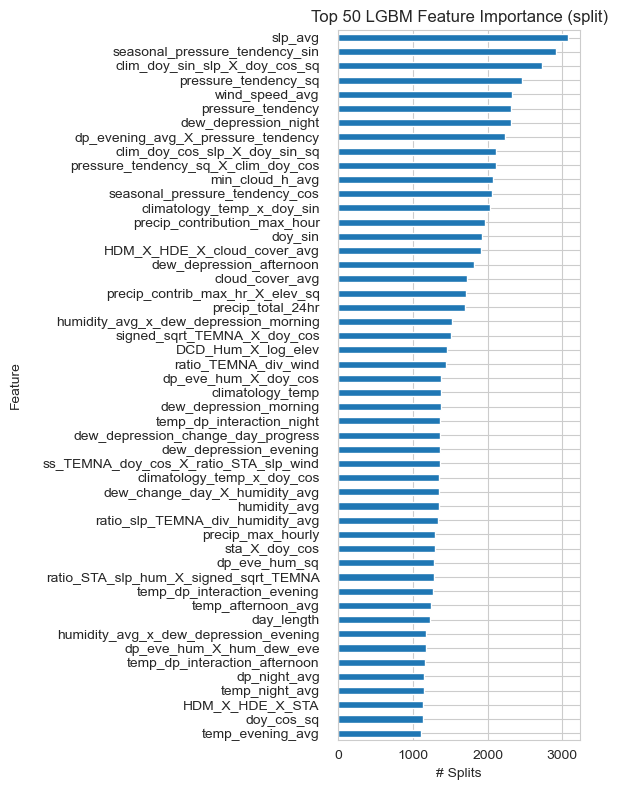

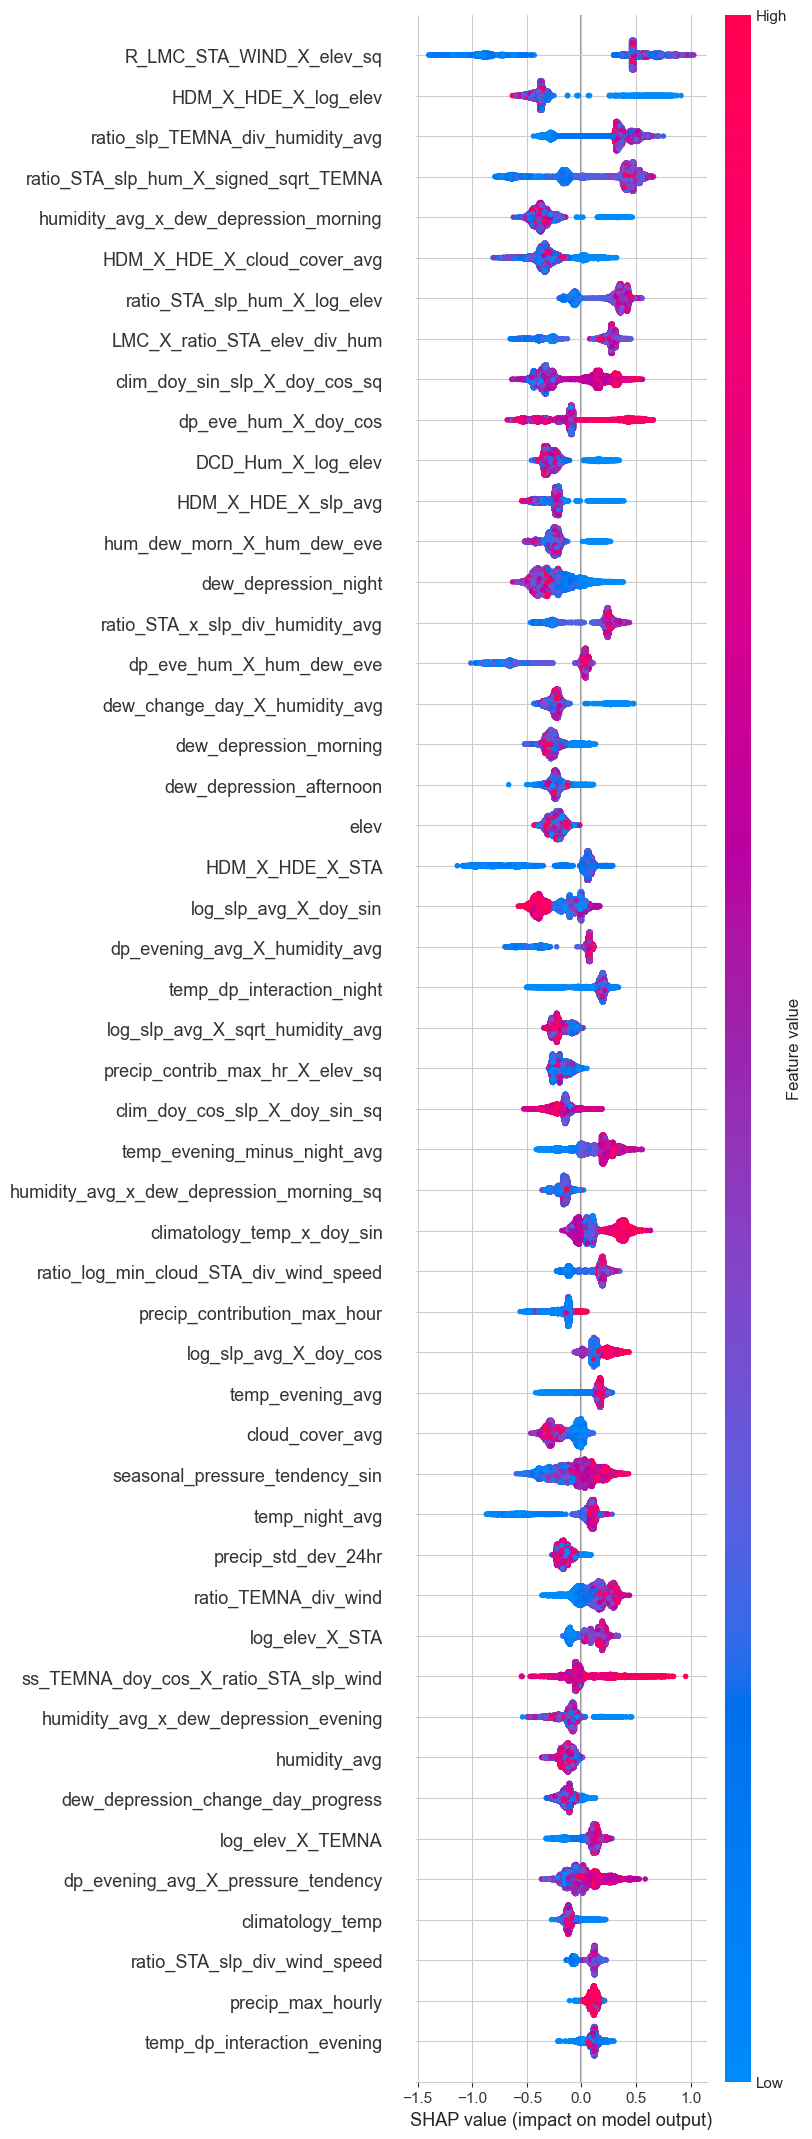

In [10]:
imp_split = lgbm.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 50

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N} LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [11]:
print(f"Top {top_N} LGBM Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 50 LGBM Importances (split):
slp_avg                                  3085
seasonal_pressure_tendency_sin           2913
clim_doy_sin_slp_X_doy_cos_sq            2735
pressure_tendency_sq                     2465
wind_speed_avg                           2330
pressure_tendency                        2318
dew_depression_night                     2310
dp_evening_avg_X_pressure_tendency       2240
clim_doy_cos_slp_X_doy_sin_sq            2112
pressure_tendency_sq_X_clim_doy_cos      2109
min_cloud_h_avg                          2075
seasonal_pressure_tendency_cos           2060
climatology_temp_x_doy_sin               2038
precip_contribution_max_hour             1965
doy_sin                                  1924
HDM_X_HDE_X_cloud_cover_avg              1910
dew_depression_afternoon                 1814
cloud_cover_avg                          1728
precip_contrib_max_hr_X_elev_sq          1717
precip_total_24hr                        1698
humidity_avg_x_dew_depression_morning    1520
s

# Feature Selection with SHAP

In [12]:
print("Lowest SHAP Importances:")
print(feat_shap_imp.tail(50).to_string())

Lowest SHAP Importances:
signed_sqrt_STA_X_slp_avg                      0.084202
dew_depression_evening                         0.083281
pressure_tendency_sq_X_clim_doy_cos            0.073145
pressure_tendency                              0.072485
dp_morning_avg                                 0.071925
ratio_STA_elev_div_humidity_avg                0.071428
doy_sin                                        0.070556
STA_slp_X_hum_dew_eve                          0.068653
signed_sqrt_TEMNA_X_doy_cos                    0.064147
slp_avg                                        0.064022
signed_sqrt_STA_X_log_elev                     0.062984
signed_sqrt_temp_evening_minus_night_avg       0.062869
min_cloud_h_avg                                0.062514
STA_x_slp_avg                                  0.062038
ratio_STA_slp_div_cloud_cover_avg              0.060471
STA_slp_X_clim_temp                            0.060066
dp_night_avg                                   0.059496
day_length             

In [13]:
print(feat_imp_split.to_string())

slp_avg                                        3085
seasonal_pressure_tendency_sin                 2913
clim_doy_sin_slp_X_doy_cos_sq                  2735
pressure_tendency_sq                           2465
wind_speed_avg                                 2330
pressure_tendency                              2318
dew_depression_night                           2310
dp_evening_avg_X_pressure_tendency             2240
clim_doy_cos_slp_X_doy_sin_sq                  2112
pressure_tendency_sq_X_clim_doy_cos            2109
min_cloud_h_avg                                2075
seasonal_pressure_tendency_cos                 2060
climatology_temp_x_doy_sin                     2038
precip_contribution_max_hour                   1965
doy_sin                                        1924
HDM_X_HDE_X_cloud_cover_avg                    1910
dew_depression_afternoon                       1814
cloud_cover_avg                                1728
precip_contrib_max_hr_X_elev_sq                1717
precip_total

# Predict with Test Dataset

In [14]:
# y_test_pred = lgbm.predict(X_test_scaled)
#
# submission = pd.DataFrame({
#     "id": test_df_final["id"],
#     "target": y_test_pred
# })
#
# now = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# submission.to_csv(f'./output/submission_{now}.csv', index=False)